In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import fitsio
import astropy
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from astropy.table import Table
from astropy.io import fits
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import dipole

In [4]:
# go through the catalogs in order
tab = Table.read(os.path.join('/scratch/aew492/quasars/catalogs/catwise_agns/catwise_agns_master.fits'))
print(f"columns: ", tab.columns)
print(f"max W1 = {max(tab['w1']):.3f}, min w1cov = {min(tab['w1cov']):.3f}")
# cut 16.4
tab = tab[(tab['w1'] <= 16.4)]
# load catalog as map
mastermap = tools.load_catalog_as_map(tab, frame='icrs', NSIDE=64)

columns:  <TableColumns names=('source_id','ra','dec','w1cov','w1','w2','w12','l','b','elon','elat','radius','radius2','pa')>
max W1 = 17.000, min w1cov = 80.000


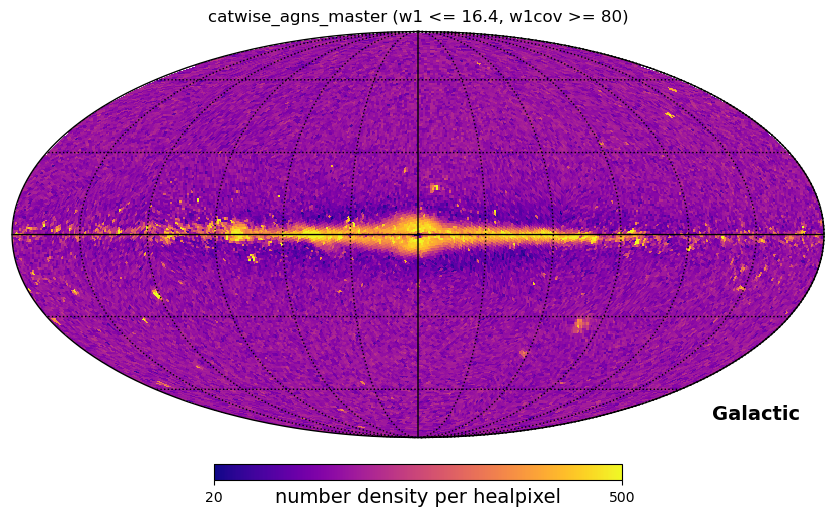

In [5]:
# plot
hpkwargs = dict(coord=['C','G'], norm='log', cmap='plasma', badcolor='w')
tools.mollview(mastermap, title='catwise_agns_master (w1 <= 16.4, w1cov >= 80)', min=20, max=500, **hpkwargs)

In [6]:
# with masks
del tab
tab = Table.read(os.path.join(S21_dir, 'catwise_agns_master_masks.fits'))
print("columns: ", tab.columns)
# W1 cut
tab = tab[(tab['w1'] <= 16.4)]
mastermasksmap = tools.load_catalog_as_map(tab, frame='icrs', NSIDE=64)
# now we have pixels with zero quasars because of the mask: replace with NaN
mastermasksmap[mastermasksmap==0.] = np.nan

columns:  <TableColumns names=('source_id','ra','dec','w1','w2','w12','l','b','elon','elat','radius','radius2','pa')>


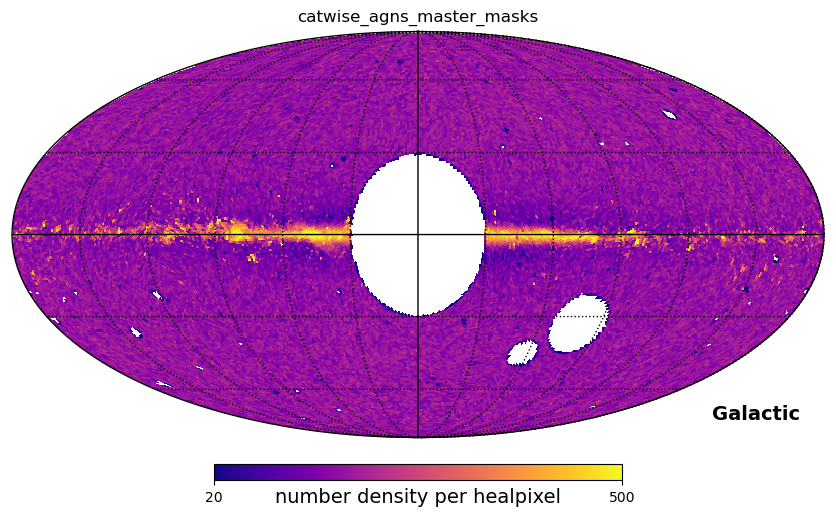

In [7]:
tools.mollview(mastermasksmap, title='catwise_agns_master_masks', min=20, max=500, **hpkwargs)

In [8]:
del tab

In [9]:
# load masks
masks = fitsio.read('/scratch/aew492/quasars/catalogs/masks/mask_master_hpx_r1.0.fits')

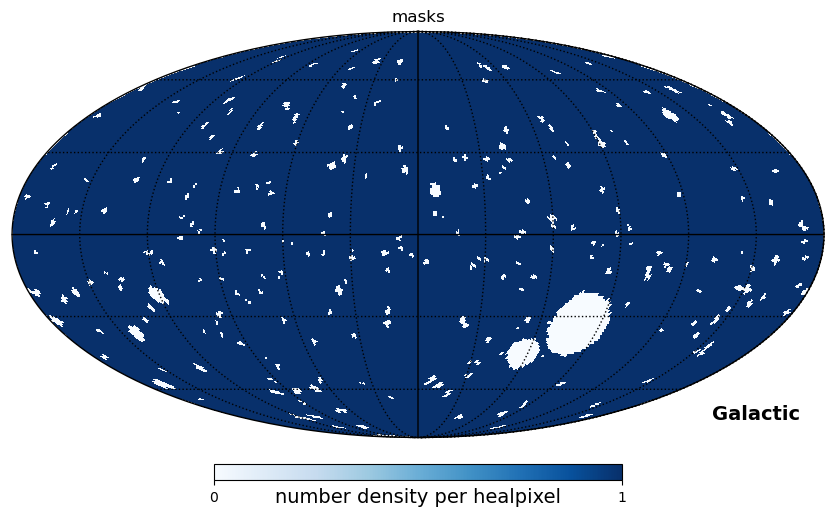

In [10]:
tools.mollview(masks, coord=['C','G'], title='masks', cmap='Blues', badcolor='w')

In [11]:
# coordinate of the galactic center
galcenter = SkyCoord(0, 0, frame='galactic', unit='deg').transform_to('icrs')
# add a galactic center mask
NSIDE = hp.npix2nside(len(masks))
galcenter_ipix = hp.query_disc(NSIDE, vec=hp.ang2vec(galcenter.ra.deg, galcenter.dec.deg, lonlat=True),
                               radius=(30*u.deg).to(u.rad).value)
galcenter_mask = np.full_like(masks, 1)
galcenter_mask[galcenter_ipix] = 0

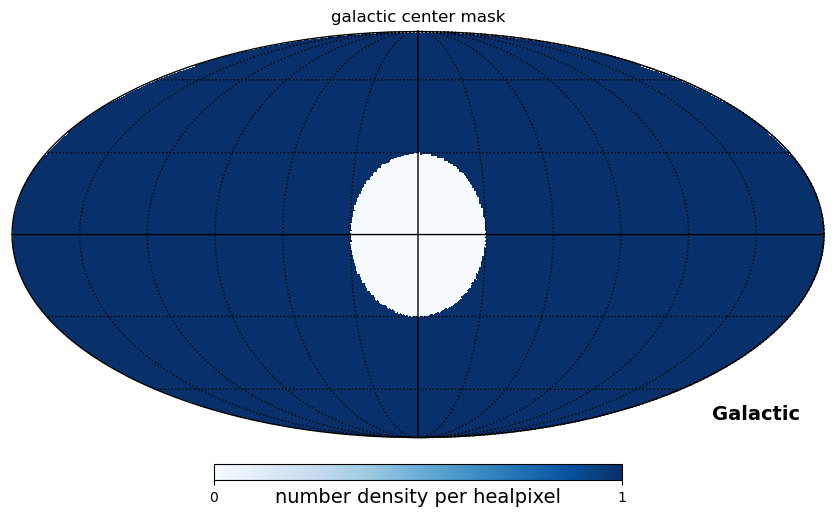

In [12]:
tools.mollview(galcenter_mask, coord=['C','G'], title='galactic center mask', cmap='Blues', badcolor='w')

In [13]:
# add the galactic center to the total masks map!
allmasks = masks.astype(bool) & galcenter_mask.astype(bool)

In [14]:
# okay now instead of using catwise_agns_master_masks (which has been masked at the source level and THEN turned into a healpix map),
#  use catwise_agns_master * allmasks (allmasks has been masked at the healpixel level)
masked_catwise_agns_master = mastermap * allmasks

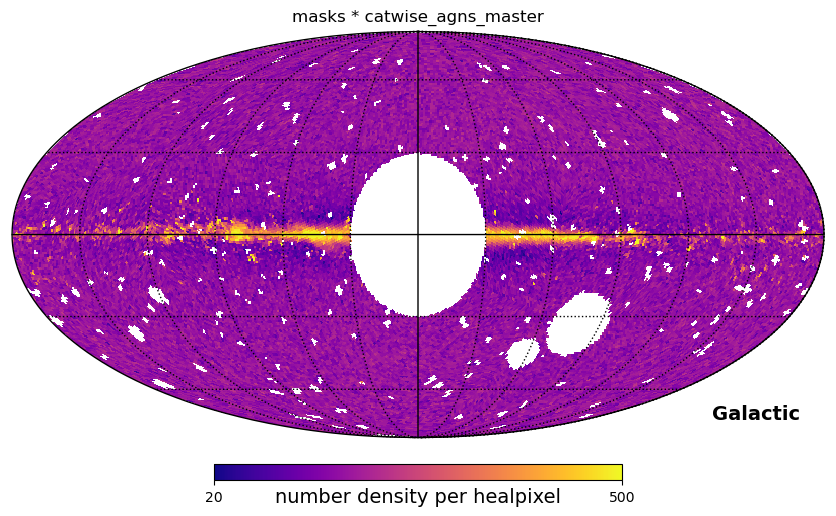

In [15]:
tools.mollview(masked_catwise_agns_master, title='masks * catwise_agns_master', min=20, max=500, **hpkwargs)

In [18]:
# okay now mask the galactic plane
blim = 15
galmask = tools.get_galactic_plane_mask(blim=blim, NSIDE=64, frame='icrs')

masked_catwise_agns_master_blim = masked_catwise_agns_master * galmask
masked_catwise_agns_master_blim[masked_catwise_agns_master_blim==0.] = np.nan

In [19]:
idx0 = np.where(masked_catwise_agns_master_blim==0)[0]
indices = np.empty((idx0.size, 8), dtype=int)
for i in range(idx0.size):
    indices[i] = hp.pixelfunc.get_all_neighbours(self.NSIDE, idx0[i])

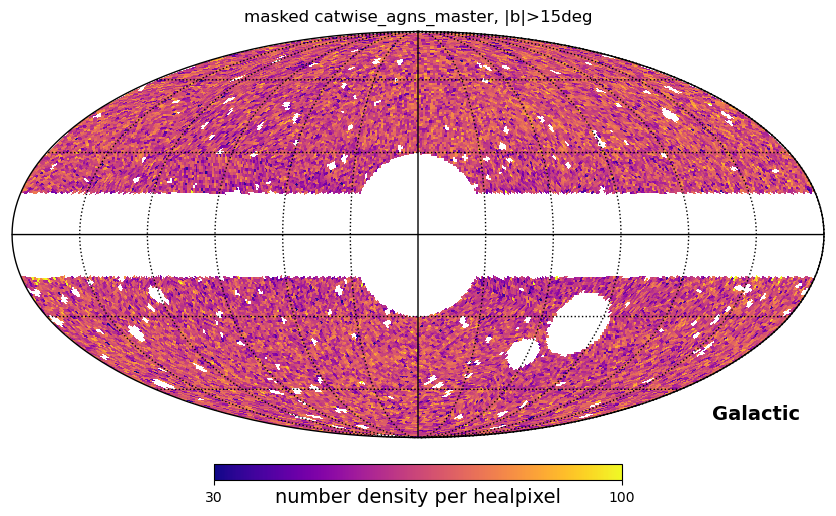

In [20]:
tools.mollview(masked_catwise_agns_master_blim, title=f'masked catwise_agns_master, |b|>{blim}deg', min=30, max=100, **hpkwargs)

In [17]:
save_fn = os.path.join(S21_dir, f'masked_catwise_agns_master_blim{blim}.fits')
# hp.write_map(save_fn, masked_catwise_agns_master_blim, coord='C')
# data = tools.flatten_map(fitsio.read(save_fn))
# tools.mollview(data, title=f'masked catwise_agns_master, |b|>{blim}deg', min=30, max=100, **hpkwargs)

### Quaia

In [46]:
# go through the catalogs in order
maglim = 20.
tab = Table.read(f'/scratch/aew492/quasars/catalogs/quaia/quaia_G{maglim:.1f}.fits')
print(f"columns: ", tab.columns)
print(f"max G = {max(tab['phot_g_mean_mag']):.3f}")
# cut magnitude 
tab = tab[(tab['phot_g_mean_mag'] <= maglim)]
# load catalog as map
mastermap = tools.load_catalog_as_map(tab, frame='icrs', NSIDE=64)

columns:  <TableColumns names=('source_id','unwise_objid','redshift_quaia','redshift_quaia_err','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','mag_w1_vg','mag_w2_vg','pm','pmra','pmdec','pmra_error','pmdec_error')>
max G = 20.000


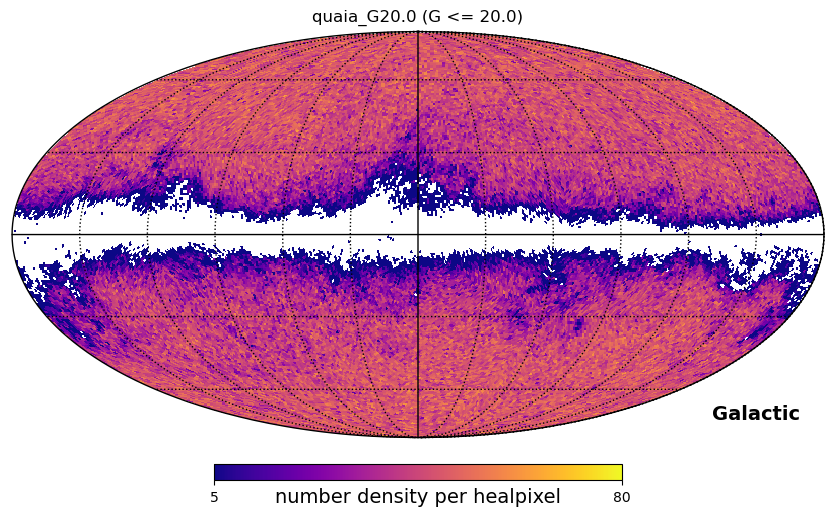

In [47]:
# plot
hpkwargs = dict(coord=['C','G'], norm='log', cmap='plasma', badcolor='w')
tools.mollview(mastermap, title=f'quaia_G{maglim:.1f} (G <= {maglim:.1f})', min=5, max=80, **hpkwargs)

In [48]:
del tab

In [49]:
# now mask using the allmasks map (smaller masks + galactic center), created above
masked_quaia_master = mastermap * allmasks

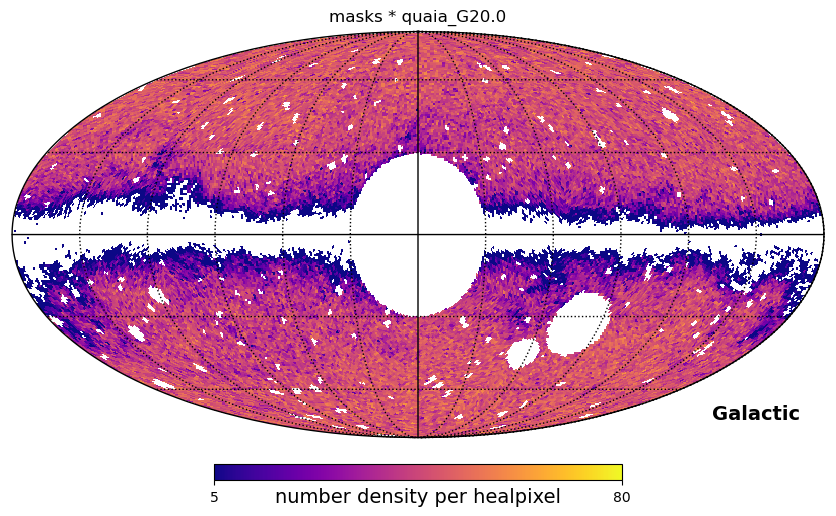

In [50]:
tools.mollview(masked_quaia_master, title=f'masks * quaia_G{maglim:.1f}', min=5, max=80, **hpkwargs)

In [51]:
# okay now mask the galactic plane
blim = 30
galmask = tools.get_galactic_plane_mask(blim=blim, NSIDE=64, frame='icrs')

masked_quaia_master_blim = masked_quaia_master * galmask
masked_quaia_master_blim[masked_quaia_master_blim==0.] = np.nan

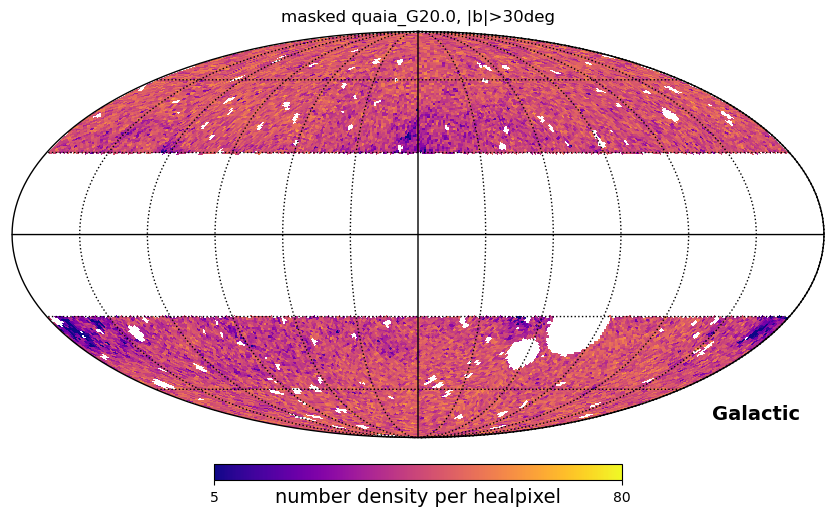

In [52]:
tools.mollview(masked_quaia_master_blim, title=f'masked quaia_G{maglim:.1f}, |b|>{blim}deg', min=5, max=80, **hpkwargs)

setting the output map dtype to [dtype('float64')]


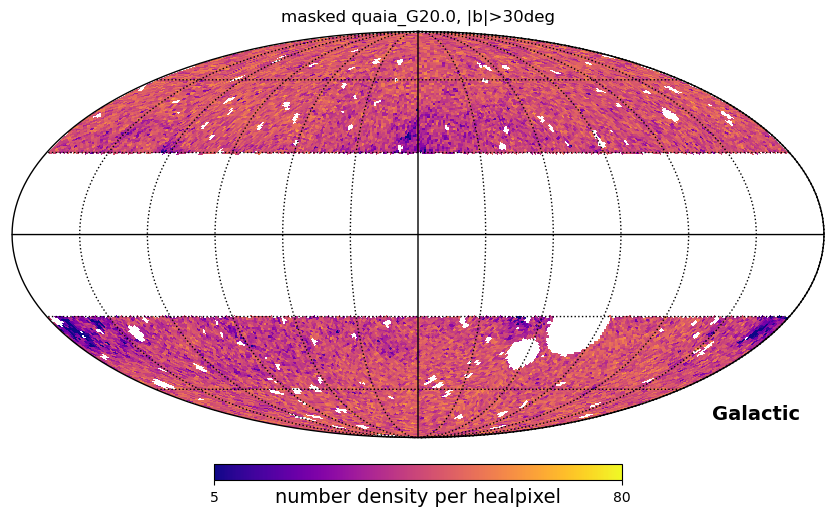

In [53]:
save_fn = f'/scratch/aew492/quasars/catalogs/quaia/masked_quaia_G{maglim:.1f}_blim{blim}.fits'
hp.write_map(save_fn, masked_quaia_master_blim, coord='C')
data = tools.flatten_map(fitsio.read(save_fn))
tools.mollview(data, title=f'masked quaia_G{maglim:.1f}, |b|>{blim}deg', min=5, max=80, **hpkwargs)